![](https://imgur.com/QnT31vZ.png)

---

# Sobre o desafio

Na semana 02, vamos focar na construção e otimização de modelos de machine learning (ML) para lidar com a Taxa de Churn. Agora que terminamos a análise inicial dos dados na semana 01, é hora de usar algoritmos de ML para transformar nossos insights em ações eficazes.

## Carregando os dados da Semana 01

In [1]:
import pandas as pd

dados = pd.read_csv('Dados/dados_tratados.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   Seniorcitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   Phoneservice      7043 non-null   object 
 7   Multiplelines     7043 non-null   object 
 8   Internetservice   7043 non-null   object 
 9   Onlinesecurity    7043 non-null   object 
 10  Onlinebackup      7043 non-null   object 
 11  Deviceprotection  7043 non-null   object 
 12  Techsupport       7043 non-null   object 
 13  Streamingtv       7043 non-null   object 
 14  Streamingmovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperlessbilling  7043 non-null   object 


<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Lidando com o desbalanceamento de dados da target</h1>
</div>

Durante a primeira semana do nosso projeto, uma observação veio à tona: nossos dados da target apresentam um desbalanceamento, conforme evidenciado abaixo:

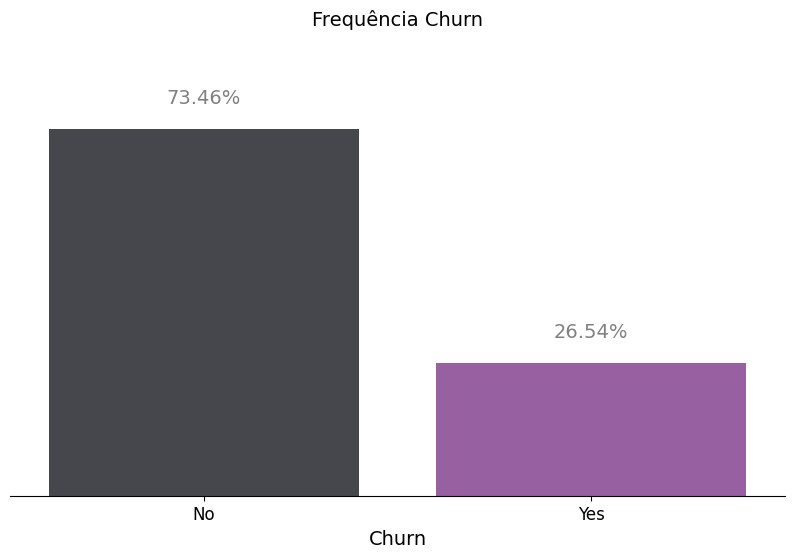

In [2]:
import justplotit as jpi
jpi.frequencia_churn(dados)

O que esse balanceamento nos diz se quisermos prever quais clientes deixaram a empresa Novexus? Quando formos criar nosso modelo de Machine Learning, treinar e avaliar, vamos eventualmente perceber que o modelo terá um bom desempenho para prever corretamente que os clientes que saíram da empresa realmente saíram, mas ele vai ter um péssimo desempenho para identificar corretamente quais clientes saíram da empresa (recall baixo e, eventualmente, o f1-score será baixo também). Assim o modelo está estaria fazendo bom trabalho em identificar clientes que não irão sair da empresa, mas está falhando em identificar clientes que irão sair da empresa.

Para melhorar o desempenho do modelo, podemos pensar em três alternativas: 

1. Deixamos esses dados balanceados adicionando mais features relevantes ao conjunto de dados de treinamento;

2. Implementar uma técnica de oversampling (SMOTE) ou

3. uma técnica de Undersampling (Tomek Links).


## Abordagem 1: Ignorar o desbalanceamento

> A primeira abordagem consiste em ignorar completamente o desbalanceamento e construir nosso modelo sem fazer ajustes específicos para corrigir. Se desenvolvermos um modelo sem considerar essa desproporcionalidade nos dados, o modelo será vítima do Paradoxo da Acurácia, em que os parâmetros do algoritmo não diferenciarão a classe minoritária das demais categorias, acreditando que estão agregando resultado devido à aparente alta acurácia.

## Abordagem 2: Oversamplig

> A segunda abordagem é utilizar a técnica [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) (Synthetic Minority Over-sampling Technique). Essa técnica envolve a criação de informações sintéticas com base nas observações já existentes na classe minoritária. Esses dados "sintéticos" são gerados de forma a serem semelhantes aos dados reais, embora não sejam idênticos. Essa abordagem visa equilibrar a representação das classes, tornando o modelo mais capaz de identificar corretamente os casos da classe minoritária. Essa técnica no entanto pde introduzir viés nos dados ao gerar amostras sintéticas que estão próximas de exemplos existentes da classe minoritária. Isso pode levar a um melhor desempenho do modelo na classe minoritária, mas pode prejudicar o desempenho do modelo na classe majoritária.

![](https://imgur.com/KCTDPZG.png)

## Abordagem 3: Undersampling

> A terceira abordagem é usar Tomek Links é uma técnica de subamostragem que foi desenvolvida em 1976 por [Ivan Tomek](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309452). É uma modificação do Condensed Nearest Neighbors (CNN). Ele pode ser utilizado para identificar amostras desejadas da classe majoritária que apresentem a menor distância euclidiana com os dados da classe minoritária e, em seguida, removê-las. 

![](https://imgur.com/6FTLQ0M.png)

## Quando iremos aplicar essas técnicas?

A regra fundamental é: nunca mexa com seu conjunto de teste. Sempre divida-o em conjuntos de teste e treinamento ANTES de tentar aplicar técnicas de oversampling/undersampling!

Realizar oversampling antes da divisão dos dados pode resultar na presença das mesmas observações em ambos os conjuntos de teste e treinamento. Isso possibilita que o modelo simplesmente memorize pontos de dados específicos, o que leva ao overfitting e à má generalização para os dados de teste. O vazamento de dados pode causar a criação de modelos preditivos excessivamente otimistas, senão completamente inválidos.

Além disso, não devemos fazer isso antes da validação cruzada. Isso ocorre porque ao fazer isso antecipadamente, você estará influenciando diretamente o conjunto de validação antes de realizar a validação cruzada, o que pode resultar em um problema de "data leakage".

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Feature Engineering e Encoding + Pipeline</h1>
</div>

Iremos adicionar uma nova variável intitulada `TotalServices`, que é uma contagem do número total de serviços que um cliente está inscrito (os serviços são: `Multiplelines`, `Onlinesecurity`, `Onlinebackup`, `Deviceprotection`, `Techsupport`, `Streamingtv`, `Streamingmovies`). Além disso, iremos substituir todas as células que possuem `No internet service` ou `No phone service` por `No` visto que já existe uma coluna que informa sobre isso.

In [3]:
import justdoit as jdi

# Precisamos separar nossos dados!
X = dados.drop('Churn', axis = 1)                # Features
y = dados['Churn'].replace({'Yes': 1, 'No': 0})  # Target

# Substituindo algumas coisas desnecessárias...
X = X.where((X != 'No internet service') & (X != 'No phone service'), 'No')

# Adicionando uma nova feature!
jdi.TotalServiceTransformer(X)

O código abaixo está preparando os dados para o modelo ML usando pipelines e transformadores. Cada linha do código é explicada abaixo:

- `cols_num` e `cols_cat`: Define as features numéricas e categóricas (respectivamente) do conjunto de dados que precisam ser pré-processadas.

Logo em seguida temos a criação do pipeline de pré-processamento para os dados categóricos e numéricos:

- A primeira etapa é o codificador `CatBoost`. É um codificador supervisionado de variáveis categóricas baseado no algoritmo CatBoost, na qual codifica essas colunas de acordo com o valor da target.

- A segunda etapa é padronizar os dados numéricos com `StandardScaler`. Isso significa que aqui vamos transformar os dados de modo que a média de cada coluna seja 0 e o desvio padrão de cada coluna seja 1.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer

cols_num = list(set(X.select_dtypes('number')))
cols_cat = list(set(X.select_dtypes('object')))

pipe_cat = Pipeline([('encoder', CatBoostEncoder())])
pipe_num = Pipeline([('std_scaler', StandardScaler())])

preprocessor = ColumnTransformer([('numeric', pipe_num, cols_num),
                                  ('categoric', pipe_cat, cols_cat)])
preprocessor

#pipeline_completo =Pipeline([('Preprocessor',preprocessor),('model', None)])

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['Tenure', 'Charges_total', 'Charges_monthly',
                                  'TotalServices', 'Seniorcitizen']),
                                ('categoric',
                                 Pipeline(steps=[('encoder',
                                                  CatBoostEncoder())]),
                                 ['Gender', 'Phoneservice', 'Dependents',
                                  'Multiplelines', 'Techsupport', 'Contract',
                                  'Onlinebackup', 'Paperlessbilling',
                                  'Streamingtv', 'Partner', 'Deviceprotection',
                                  'Onlinesecurity', 'Internetservice',
                                  'Streamingmovies', 'Paymentmethod'])])

A partir deste ponto, nosso trabalho se ramificará nas três abordagens distintas que falamos anteriormente. Ao final, identificaremos qual delas é a mais eficaz, juntamente com a escolha do modelo de classificação adequado. Também discutiremos as medidas que a empresa Novexus pode adotar para reduzir a taxa de Churn.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Construção do modelo</h1>
</div>

## Conjunto de treino e teste

In [5]:
from sklearn.model_selection import train_test_split

n = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = n)

##  Usando K-fold Cross-Validation

Uma maneira eficaz de avaliar o desempenho de um modelo de machine learning é através da validação cruzada, especificamente usando a técnica chamada de **K-fold Cross-Validation**. Em vez de simplesmente dividir o conjunto de treinamento em um grupo de treinamento e outro de validação, essa abordagem envolve dividir o conjunto de treinamento em **K** subconjuntos distintos chamados "folds". Em seu exemplo, usamos **K = 3**, o que significa que o conjunto de treinamento será dividido em 3 folds.

A ideia principal por trás do K-fold Cross-Validation é treinar e avaliar o modelo K vezes, onde em cada iteração um fold diferente é escolhido para ser o conjunto de validação, enquanto os outros **K - 1** folds são usados para treinamento. Isso nos permite obter várias estimativas do desempenho do modelo, reduzindo o impacto da aleatoriedade na divisão dos dados em apenas dois grupos (treinamento e validação).

Aqui entra em cena a observação sobre **`RepeatedStratifiedKFold`**. A estratégia de divisão dos dados em folds é importante para garantir que as classes estejam balanceadas em cada fold, especialmente quando lidamos com conjuntos de dados desequilibrados, onde uma classe tem muitos mais exemplos do que a outra. O `RepeatedStratifiedKFold` é uma variação do K-fold que mantém essa estratégia de divisão estratificada e também permite repetir o processo várias vezes para aumentar a robustez da avaliação do modelo. Em outras palavras, ele ajuda a garantir que a avaliação do modelo seja consistente e não dependa da aleatoriedade na escolha dos folds.

**Observação:** Oversampling e Undersampling foram usados apenas no conjunto de treinamento durante o Cross Validation!!!

In [7]:
df_over = jdi.cross_validation_models_set('Oversampling', preprocessor, X_train, y_train)
df_over.sort_values('Recall', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.840,0.739,0.503,0.809,0.622
5,Support Vector Machine,0.832,0.742,0.505,0.804,0.622
1,K-Vizinhos Mais Próximos (KNN),0.773,0.705,0.468,0.744,0.578
4,Gradient Boosting,0.839,0.782,0.584,0.660,0.623
3,Floresta Randômica,0.835,0.792,0.617,0.576,0.595
2,Árvore de Decisão,0.667,0.724,0.476,0.519,0.495


In [9]:
df_under = jdi.cross_validation_models_set('Undersampling', preprocessor, X_train, y_train)
df_under.sort_values('Recall', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.840,0.796,0.615,0.617,0.616
4,Gradient Boosting,0.845,0.799,0.624,0.610,0.617
1,K-Vizinhos Mais Próximos (KNN),0.786,0.762,0.547,0.601,0.572
3,Floresta Randômica,0.835,0.793,0.615,0.590,0.602
2,Árvore de Decisão,0.676,0.725,0.491,0.572,0.525
5,Support Vector Machine,0.813,0.793,0.634,0.525,0.574


In [8]:
df_def = jdi.cross_validation_models_set('Default', preprocessor, X_train, y_train)
df_def.sort_values('Recall', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.840,0.801,0.656,0.527,0.584
1,K-Vizinhos Mais Próximos (KNN),0.780,0.767,0.567,0.524,0.545
4,Gradient Boosting,0.845,0.802,0.662,0.522,0.583
2,Árvore de Decisão,0.659,0.728,0.492,0.512,0.497
3,Floresta Randômica,0.834,0.794,0.658,0.470,0.546
5,Support Vector Machine,0.797,0.793,0.668,0.436,0.527


### Análise preliminar

Após o treinamento de 6 modelos, percebemos que, a Regressão Logística foi o melhor modelo nas três abordagens em relação ao Recall.

Escolheremos mais dois modelos com melhor desempelho nessa métrica e faremos um hyperparameter tuning usando Grid Search.

> Regressão Logística, Support Vector Machine e Gradient Boosting.

## Hyperparameter tuning usando Grid Search

Vamos configurar a grade de parâmetros para cada modelo:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

svm_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear']
}

gradient_boosting_params = {
    'model__learning_rate': [0.1, 0.01],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5]
}

logistic_regression_params = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [1000]
}


modelos = {
    'Gradient Boosting': (GradientBoostingClassifier(random_state = n), gradient_boosting_params),
    'Logistic Regression': (LogisticRegression(random_state = n), logistic_regression_params),
    'Support Vector Machine (Linear Kernel)': (SVC(random_state = n), svm_params)
}

### Oversampling

In [12]:
from imblearn.over_sampling import SMOTE
gs_over = jdi.hyperparameter_optimization(SMOTE(), preprocessor, X_train, y_train, modelos)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
Best parameters for Logistic Regression: {'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best parameters for Support Vector Machine (Linear Kernel): {'model__C': 0.1, 'model__kernel': 'linear'}


In [13]:
gs_over.sort_values('Recall', ascending = False)

,model,F1_score,Recall
1,Logistic Regression,0.718401,0.762934
0,Gradient Boosting,0.706403,0.758392
2,Support Vector Machine (Linear Kernel),0.691561,0.751614


### Undersampling

In [14]:
from imblearn.under_sampling import TomekLinks
gs_under = jdi.hyperparameter_optimization(TomekLinks(), preprocessor, X_train, y_train, modelos)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best parameters for Logistic Regression: {'model__C': 1, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best parameters for Support Vector Machine (Linear Kernel): {'model__C': 10, 'model__kernel': 'linear'}


In [15]:
gs_under.sort_values('Recall', ascending = False)

,model,F1_score,Recall
0,Gradient Boosting,0.737797,0.746724
1,Logistic Regression,0.737603,0.739565
2,Support Vector Machine (Linear Kernel),0.730297,0.728779


### Default

In [16]:
gs_def = jdi.hyperparameter_optimization(None, preprocessor, X_train, y_train, modelos)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best parameters for Logistic Regression: {'model__C': 10, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best parameters for Support Vector Machine (Linear Kernel): {'model__C': 10, 'model__kernel': 'linear'}


In [17]:
gs_def.sort_values('Recall', ascending = False)

,model,F1_score,Recall
0,Gradient Boosting,0.731286,0.736232
1,Logistic Regression,0.725899,0.713922
2,Support Vector Machine (Linear Kernel),0.721790,0.709941


Observe o seguinte:

- Na **estratégia de Oversampling**, o melhor modelo, a Regressão Logística, conseguiu atingir um Recall de 76.29%.
- Na **estratégia de Oversampling** e na **estratégia Default**, o melhor modelo, a Gradient Boosting, conseguiu atingir um Recall de 74.67% e 73.62% respectivamente.

Apesar dos três modelos terem pontuações muito próximas, a estratégia de Oversampling superou as outras duas abordagens. Vamos, portanto, utilizar esses três melhores modelos para avaliar no conjunto de teste e, em seguida, determinar definitivamente qual é o melhor modelo para prosseguirmos com o lançamento.

Regressão Logística e Gradient Boosting como melhores modelos

In [51]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as PipelineIMB
from sklearn.ensemble import GradientBoostingClassifier

# Oversampling {'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
logistic_regression = LogisticRegression(C = 0.1, max_iter = 1000, penalty = 'l2', solver = 'liblinear', random_state = n)
pipe_over = PipelineIMB([('preprocessor', preprocessor), ('resampler', SMOTE()), ('model', logistic_regression)])
pipe_over.fit(X_train, y_train)

# Undersampling {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
gradient_boosting_under = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 100, random_state = n)
pipe_under = PipelineIMB([('preprocessor', preprocessor), ('resampler', TomekLinks()), ('model', gradient_boosting_under)])
pipe_under.fit(X_train, y_train)

# Default {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
gradient_boosting_def = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = n)
pipe_def = PipelineIMB([('preprocessor', preprocessor), ('model', gradient_boosting_def)])
pipe_def.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'Charges_total',
                                                   'Charges_monthly',
                                                   'TotalServices',
                                                   'Seniorcitizen']),
                                                 ('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['Gender', 'Phoneservice',
                                                   'Dependents',
                                                   'Multiplelines',
                                                   'Techsupport', 'Contract',
                                                   'Onlinebackup',
                                                   'Paperlessbilling',
                                                   'Streamingtv', 'Partner',
                                                   'Deviceprotection',
                                                   'Onlinesecurity',
                                                   'Internetservice',
                                                   'Streamingmovies',
                                                   'Paymentmethod'])])),
                ('model', GradientBoostingClassifier(random_state=42))])

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Avaliação dos modelos</h1>
</div>

## Previsões dos Modelos

In [27]:
lr_predictions = pipe_over.predict(X_test)
gb_under_predictions = pipe_under.predict(X_test)
gb_def_predictions = pipe_def.predict(X_test)

## Comparação dos valores reais com os valores previstos

In [28]:
from sklearn.metrics import classification_report

rf_report = classification_report(y_test, lr_predictions)
print("Relatório de Classificação para Regressão Logística (Oversampling):")
print(rf_report)

Relatório de Classificação para Regressão Logística (Oversampling):
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



A Regressão Logística com Oversampling possui um recall relativamente alto para a classe 1 (clientes propensos ao churn), mas a precisão é um pouco baixa. Isso significa que o modelo identifica a maioria dos clientes propensos ao churn, mas também gera alguns falsos positivos.

In [29]:
gb_under_report = classification_report(y_test, gb_under_predictions)
print("\nRelatório de Classificação para Gradient Boosting (Undersampling):")
print(gb_under_report)


Relatório de Classificação para Gradient Boosting (Undersampling):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1035
           1       0.62      0.61      0.61       374

    accuracy                           0.80      1409
   macro avg       0.74      0.74      0.74      1409
weighted avg       0.79      0.80      0.80      1409



O Gradient Boosting com Undersampling tem um equilíbrio razoável entre precisão e recall para a classe 1. Embora a precisão seja melhor do que a da Regressão Logística com Oversampling, o recall é um pouco inferior.

In [30]:
gb_def_report = classification_report(y_test, gb_def_predictions)
print("\nRelatório de Classificação para Gradient Boosting (Default sampling):")
print(gb_def_report)


Relatório de Classificação para Gradient Boosting (Default sampling):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



O Gradient Boosting com amostragem padrão tem uma precisão um pouco melhor para a classe 1 em comparação com o modelo com Undersampling. No entanto, o recall é o mais baixo entre os modelos analisados, o que significa que ele está perdendo mais clientes propensos ao churn.

Resumindo, ao analisar as métricas de precisão, recall, pontuação F1 e acurácia:

- A Regressão Logística com Oversampling tem o recall mais alto, mas a precisão é um pouco baixa.
- O Gradient Boosting com Undersampling equilibra razoavelmente precisão e recall.
- O Gradient Boosting com amostragem padrão tem a melhor precisão para a classe 1, mas o recall é mais baixo.

### "Melhor modelo" de acordo com a problemática

Embora a precisão do modelo seja uma métrica comumente usada para avaliar o desempenho de modelos de ML, acreditamos que não deve ser o único fator decisivo para selecionar o modelo mais adequado para prever o churn de clientes. Devido à natureza do setor de telecomunicações, onde o custo de atrair novos clientes supera o custo de manter os existentes, o recall, que representa a capacidade do modelo de identificar com precisão os casos positivos (clientes propensos ao churn), torna-se uma métrica crítica.

Considerando os resultados apresentados anteriormente, é evidente que o modelo Regressão Logística, utilizando a abordagem de oversampling, se destaca em relação ao recall médio ponderado (macro avg recall) entre os três modelos avaliados. Este modelo demonstrou a capacidade de prever com maior precisão os casos reais de ocorrência de churn, resultando na menor taxa de falsos negativos. Portanto, com base em nossa estratégia de retenção de clientes, onde minimizar os falsos negativos é fundamental para evitar a perda de clientes, consideramos o modelo Regressão Logística com oversampling como a escolha mais adequada para prever a probabilidade de um cliente churn.

## Visualizando a matriz de confusão para o Regressão Logística

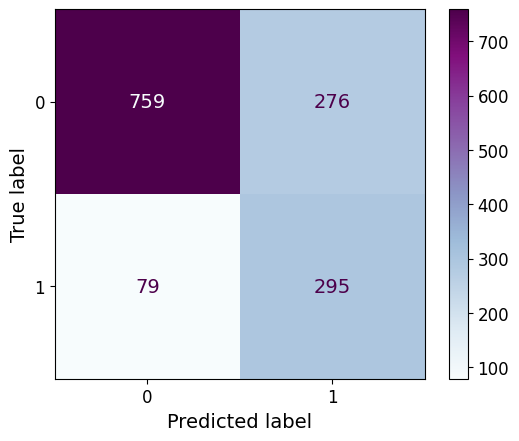

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, lr_predictions, labels=pipe_over.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = pipe_over.classes_)
disp = disp.plot(cmap = plt.cm.BuPu)
plt.grid(False);

- **Verdadeiros Positivos (TP):** Estes representam os clientes identificados corretamente como propensos ao churn (classe 1) pelo modelo, e que de fato estavam em risco de churn. Neste caso, há 295 verdadeiros positivos, o que é positivo, pois permite tomar medidas de retenção eficazes.

- **Verdadeiros Negativos (TN):** Aqui estão os clientes corretamente classificados pelo modelo como não propensos ao churn (classe 0), e que realmente não estavam em risco de churn. Com 759 verdadeiros negativos, evitam-se gastos desnecessários em ações de retenção para esses clientes.

- **Falsos Positivos (FP):** Estes são casos em que o modelo erroneamente previu que um cliente estava propenso ao churn (classe 1), mas na realidade, o cliente não estava em risco de churn (classe 0). Com 276 falsos positivos, há o risco de investir recursos em clientes que não necessitam de medidas de retenção.

- **Falsos Negativos (FN):** Os falsos negativos representam clientes que o modelo falhou em identificar como propensos ao churn (classe 0), mas que, na verdade, estavam em risco de churn (classe 1). Com 79 falsos negativos, existe uma pequena preocupação de perder a oportunidade de implementar ações de retenção para clientes que podem estar considerando deixar a empresa.

## Visualizando ROC e AUC para o Modelo Regressão Logística

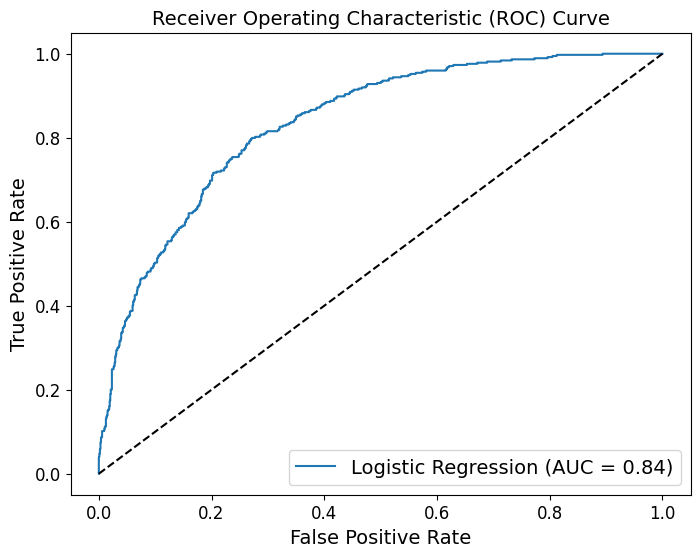

In [40]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

y_pred_prob = pipe_over.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

O AUC varia de 0 a 1, onde um AUC de 0.5 representa um desempenho aleatório, e um AUC de 1 representa um desempenho perfeito (modelo capaz de separar completamente as classes). Aqui, nosso modelo obteve um AUC de 0.84, o que indica que ele possui uma boa capacidade de distinguir entre clientes propensos ao churn e clientes não propensos ao churn.

## Model Explainer (SHAP): Feature Importance e Waterfall 

### Feature Importance

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


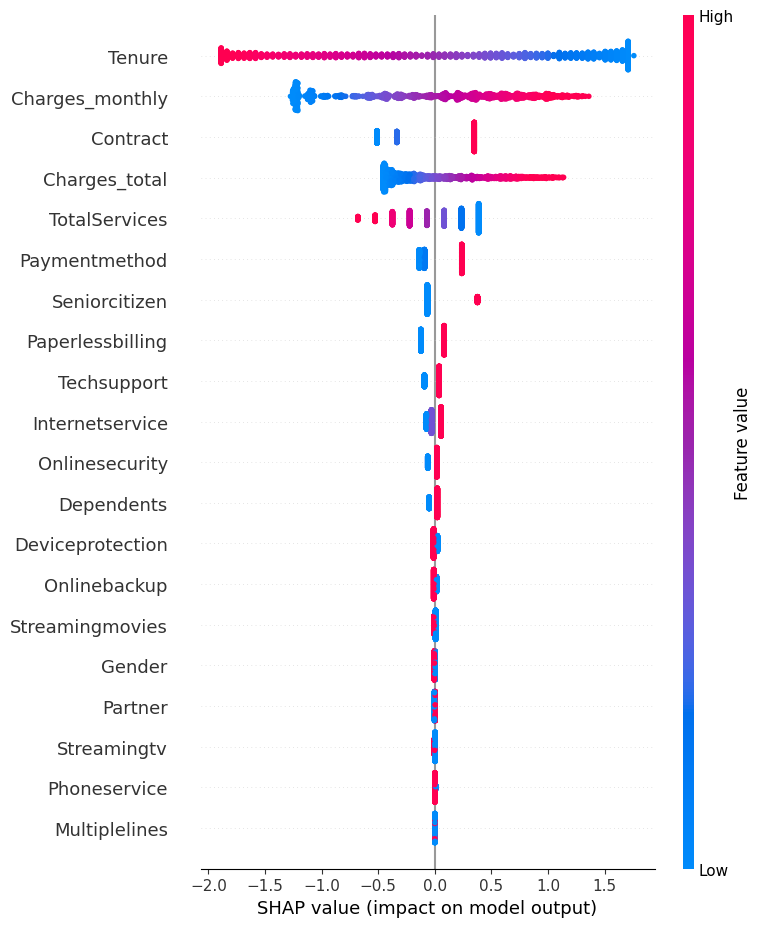

In [103]:
import shap
shap.initjs() 

feature_names = [name.split('__')[-1] for name in preprocessor.get_feature_names_out()]

X_shap = preprocessor.transform(X)
test_shap = preprocessor.transform(X_test)
explainer =  shap.LinearExplainer(pipe_over.named_steps['model'], X_shap)
shap_values = explainer.shap_values(test_shap)

shap.summary_plot(shap_values, test_shap, feature_names = feature_names);

No gráfico, o eixo y representa as variáveis do modelo, enquanto o eixo x ilustra o impacto dessas variáveis no modelo. Cada ponto no gráfico corresponde aos valores SHAP (Shapley additive explanations) para cada instância, ou seja, cada cliente, no conjunto de teste. Quando esses valores são deslocados para a esquerda no eixo x, isso indica um impacto negativo, ou seja, essas variáveis estão contribuindo para a previsão da classe 0 (não churn). Por outro lado, quando esses valores se deslocam para a direita no eixo x, eles têm um impacto positivo, auxiliando na previsão da classe 1 (churn). A codificação das cores no gráfico diferencia os valores altos (em vermelho) dos valores baixos.

A interpretação específica das variáveis é a seguinte:

- Para a variável "Tenure", valores baixos contribuem para a previsão da classe 1, enquanto valores altos contribuem para a previsão da classe 0.
- Valores altos da variável "Charges_monthly" fortalecem a previsão da classe 1, enquanto valores baixos fortalecem a previsão da classe 0. Isso também se aplica à variável "Charges_total".

É importante notar que as outras variáveis têm uma contribuição cada vez menor na previsão do modelo.

### Waterfall

In [148]:
X_test.iloc[1]

Gender                          Male
Seniorcitizen                      1
Partner                           No
Dependents                        No
Tenure                            11
Phoneservice                     Yes
Multiplelines                    Yes
Internetservice          Fiber optic
Onlinesecurity                    No
Onlinebackup                     Yes
Deviceprotection                 Yes
Techsupport                      Yes
Streamingtv                      Yes
Streamingmovies                  Yes
Contract              Month-to-month
Paperlessbilling                 Yes
Paymentmethod       Electronic check
Charges_monthly                111.4
Charges_total                1183.05
TotalServices                      6
Name: 2301, dtype: object

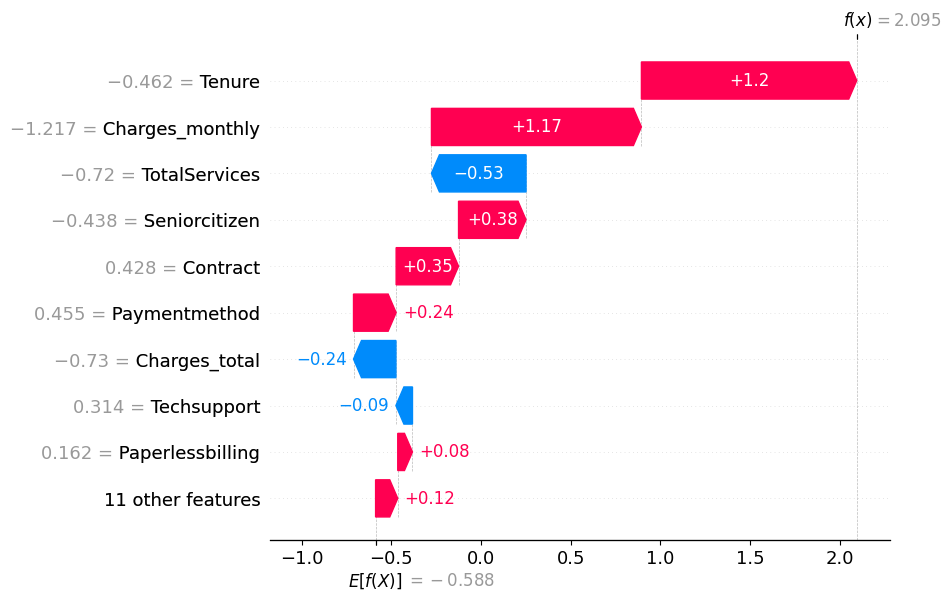

In [149]:
sv = explainer.shap_values(test_shap[[1]])
exp = shap.Explanation(sv, explainer.expected_value, data = test_shap, feature_names = feature_names)
shap.plots.waterfall(exp[0])

A cor azul representa os fatores que não resultam em Churn (ou seja, a retenção do cliente), enquanto o vermelho indica os fatores que contribuem para o Churn (a perda do cliente). Essa análise é direcionada a previsões individuais e, portanto, auxilia na tomada de decisões sobre como abordar o cliente para garantir sua permanência.

No exemplo mencionado, observamos que o cliente possui um histórico relativamente curto de 11 meses e um contrato mensal, ambos sendo indicativos de maior probabilidade de Churn. Além disso, o cliente utiliza um serviço de Internet de fibra óptica, que tem uma alta taxa de Churn associada. Além disso, o cliente apresenta um gasto mensal elevado e opta pelo pagamento por cheque.

Essa combinação de características sugere um perfil propenso a Churn. Algumas estratégias a serem consideradas incluem:

1. Oferecer ao cliente um contrato anual com descontos e incentivos atrativos para incentivá-lo a permanecer.

2. Investigar as razões por trás da alta taxa de Churn associada à fibra óptica e tomar medidas para reduzir essa probabilidade.

3. Incentivar o cliente a aderir ao Faturamento Automático como método de pagamento, o que elimina a necessidade de pagamento mensal manual e reduz as chances de Churn.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Salvando o melhor modelo: Regressão Logística</h1>
</div>

In [150]:
import joblib

pipeline_final = PipelineIMB([('preprocessor', preprocessor), 
                              ('resampler', SMOTE()), 
                              ('model', logistic_regression)])

joblib.dump(pipeline_final, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Recomendação para a Novexus</h1>
</div>

1. **Priorizar Contratos de Longo Prazo**:
   A análise de dados demonstra claramente que os clientes com contratos de maior duração têm maior probabilidade de permanecerem com a Novexus. Portanto, recomendamos que a empresa mantenha o foco principal em oferecer planos de contrato anual tradicionais. Aloque recursos significativos de marketing e promoções para esses planos, fornecendo valor adicional aos clientes para incentivá-los a renovar seus contratos. Isso contribuirá para a fidelização da marca e construção de relacionamentos de longo prazo.

2. **Planos Sem Contrato Fixo como Alternativa**:
   Os planos sem contrato fixo têm seu lugar no mercado, mas é importante reconhecer que eles são mais adequados como uma alternativa aos planos de contrato anual. Eles podem ser eficazes na aquisição de clientes a curto prazo, mas também são propensos a uma alta taxa de churn. Portanto, recomendamos que a Novexus os ofereça como uma opção secundária, mantendo o foco principal nos planos de contrato.

3. **Promoção da Fibra Óptica**:
   Para combater a alta taxa de churn entre os clientes de fibra óptica, considere oferecer descontos especiais para incentivá-los a permanecer. A fibra óptica oferece velocidades de transferência de dados muito mais altas em comparação com o DSL, o que é uma vantagem significativa para muitos clientes. É interessante de comunicar claramente esses benefícios aos clientes de fibra óptica e ofereça descontos competitivos para mantê-los satisfeitos.

4. **Redução do Processamento de Cheques Eletrônicos**:
   Dada a alta rotatividade de clientes associada ao processamento de cheques eletrônicos, é aconselhável avaliar a possibilidade de incentivar os clientes a migrarem para métodos de pagamento mais eficientes, como pagamentos com cartão de crédito. Explique as vantagens do processamento de cartões, como taxas de processamento mais baixas e maior conveniência. Ofereça incentivos para que os clientes façam essa transição, reduzindo assim a taxa de churn.
